# Light curve minima fitter and O-C calculator (written in python 2 !)

As shape of the minimum of pulsating stars varies by time, each minimum is fitted by a polynomial individually in a given phase interval.

Errors are estimate with MCMC. __This method is slow and errors are usually underestimated!__

In [1]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import glob
from matplotlib.backends.backend_pdf import PdfPages
from astropy.convolution.kernels import Box1DKernel, Gaussian1DKernel
from astropy.convolution import convolve
import pandas as pd
import collections
from lmfit import Model
import lmfit
from scipy.optimize import curve_fit
import pymc
from pymc.Matplot import plot
from multiprocessing import Pool

def load_sectors(name,format):
    print 'Loading data...'
    for i,field in enumerate( glob.glob(name+format) ):
        if i==0:
            lc = np.loadtxt('%s' % field, usecols=(0,1,2))
        else:
            lc = np.vstack((lc, np.loadtxt('%s' % field, usecols=(0,1,2))  ))

    lc = lc[ np.isfinite(lc[:,0]) ]
    lc = lc[ np.isfinite(lc[:,1]) ]
    lc = lc[ np.isfinite(lc[:,2]) ]
    lc = lc[lc[:,0].argsort()]
    return lc

def split_data_label(data):
    print 'Splitting data...'
    df = pd.DataFrame(data)
    median_diff = np.nanmedian(df[0].diff().as_matrix())
    diffs= df[0].diff() > 10.*median_diff
    labels = diffs.apply(lambda x: 1 if x else 0).cumsum()
    data = np.column_stack((data,labels))

    counter=collections.Counter(labels)
    splits = counter.keys()

    return data,splits

def sigma_clipping(time,mag,sigma,err=None,plot=False,kernel='Gaussian',width=0.1):
    print 'Sigma clipping...'
    if plot:
        time_in = time
        mag_in = mag

    if kernel=='Median':
        smoothed_signal_g = [np.median(mag) for i in mag]

    if kernel=='Box':
        smooth_width_g = width/((time[-1]-time[0])/len(time))
        smoothed_signal_g = convolve(mag, Box1DKernel(smooth_width_g),boundary="extend")

    if kernel=='Gaussian':
        smooth_width_g = width/((time[-1]-time[0])/len(time))
        smoothed_signal_g = convolve(mag, Gaussian1DKernel(smooth_width_g),boundary="extend")

    #plt.plot(time,mag,'ko')
    #plt.plot(time,smoothed_signal,'r')
    #plt.plot(time,smoothed_signal_g,'g')
    #plt.show()

    while True:
        if plot:
            plt.plot(time,mag,'ko',label='Original data')
            #plt.plot(time,smoothed_signal,'r')
            plt.plot(time,smoothed_signal_g,'g',label='Smooth')
            plt.suptitle('Cleaning in progress...')
            plt.legend()
            plt.show()

        residual = mag-smoothed_signal_g
        upper_limit = np.mean(residual)+sigma*np.std(residual)
        lower_limit = np.mean(residual)-sigma*np.std(residual)

        if plot:
            plt.plot(time,residual,'ko',label='Residual data')
            plt.axhline(upper_limit,label='Upper/lower clipping limit')
            plt.axhline(lower_limit,label='__nolegend__')
            plt.suptitle('Cleaning in progress...')
            plt.legend()
            plt.show()

        um = np.where( (lower_limit<=residual) & (residual<=upper_limit) )
        prev_number_of_points = len(time)
        time = time[um]
        mag = mag[um]
        if err is not None:
            err = err[um]

        if len(time) == prev_number_of_points:
            break

        if kernel=='Median':
            smoothed_signal_g = [np.median(mag) for i in mag]

        if kernel=='Box':
            smooth_width_g = width/((time[-1]-time[0])/len(time))
            smoothed_signal_g = convolve(mag, Box1DKernel(smooth_width_g),boundary="extend")

        if kernel=='Gaussian':
            smooth_width_g = width/((time[-1]-time[0])/len(time))
            smoothed_signal_g = convolve(mag, Gaussian1DKernel(smooth_width_g),boundary="extend")

    if plot:
        plt.suptitle('Cleaned data')
        plt.plot(time_in,mag_in,'ko',label='Original data')
        plt.plot(time,mag,'ro',label='Cleaned data')
        plt.xlabel('Time')
        plt.ylabel('Brightness')
        plt.legend()
        plt.show()

    if err is not None:
        return time,mag,err
    else:
        return time,mag

def poly_lm(t,p, shift_h):
    f = 0.0
    t_new = [0]*len(t)
    for i in range(len(t)):
        t_new[i] = t[i] + shift_h
    f = np.polyval(p, t_new)
    return f

def logL(x,y,sig,model,model_params=None):
    #Khi2 LogLikelihood
    n = len(y)
    if model_params is not None:
        L = ( n/2.*np.log(2*np.pi*sig**2) - ((y-model(x,model_params))**2)/(2*sig**2) ).sum()
    else:
        L = ( n/2.*np.log(2*np.pi*sig**2) - ((y-model(x))**2)/(2*sig**2) ).sum()
    return -L

def mintime_parallel(params):
    t, zero_time, pm = params[-3:]
    z_fit = params[:-3]
    p_fit = np.poly1d(z_fit)
    result = minimize_scalar(p_fit, bounds=(t-zero_time-pm, t-zero_time+pm), method='bounded')
    return result.x + zero_time

def calculate_mintimes(name,lc,period,range_from=0.1,range_to=0.2,n_range=20,order=3,plot=False,npools=1):
    print 'Calculating minima times...'
    pp = PdfPages(name+'_minima_fit.pdf')

    x = lc[:,0]
    y = lc[:,1]
    err = lc[:,2]

    um = np.where(x<x[0]+period)[0]
    um2 = np.argmin( y[um] )

    mintimes = [] #List to store times of minima

    zero_time = np.floor(x[0])

    mean_t = x[um][um2]
    # Fit the data
    pm = period*0.1 #days
    z = np.polyfit(x[um]-zero_time, y[um], 3)
    p = np.poly1d(z)
    result = minimize_scalar(p, bounds=(mean_t-zero_time-pm, mean_t-zero_time+pm), method='bounded')
    mean_t = result.x + zero_time

    if plot:
        plt.scatter(x[um],y[um],label='First cycle')
        plt.axvline( x[um][um2],label='Epoha' )
        plt.xlabel('Time')
        plt.ylabel('Brightness')
        plt.suptitle(name)
        plt.legend()
        plt.show()

    i=1 #First minimum
    while True:
        t_final = None
        sig = np.inf
        for period_range in np.linspace(range_from,range_to,n_range):
            #Range to be fitted around the expected minimum:
            pm = period*period_range #days

            #If the number of points is less than 10 do not fit
            pm_initial = period*range_to #days
            um=np.where((mean_t-pm_initial<x) & (x<=mean_t+pm_initial)  )
            if len(x[um])<(pm/0.0208*0.2):
                um_final = um
                pm_final = pm
                continue

            # Fit the data
            z = np.polyfit(x[um]-zero_time, y[um], order)
            p = np.poly1d(z)

            result = minimize_scalar(p, bounds=(mean_t-zero_time-pm_initial, mean_t-zero_time+pm_initial), method='bounded')
            t_initial = result.x + zero_time

            #Continue if point number is low
            um=np.where((t_initial-pm<x) & (x<=t_initial+pm)  )
            um_before = np.where((t_initial-pm<x) & (x<=t_initial)  )
            um_after = np.where((t_initial<x) & (x<=t_initial+pm)  )
            if len(x[um_before])<(pm/0.0208*0.2) or len(x[um_after])<(pm/0.0208*0.2):
                um_final = um
                pm_final = pm
                continue

            # Fit the data
            z = np.polyfit(x[um]-zero_time, y[um], order)
            p = np.poly1d(z)

            result = minimize_scalar(p, bounds=(t_initial-zero_time-pm, t_initial-zero_time+pm), method='bounded')
            t = result.x + zero_time

            #plt.plot(x[um]-zero_time,p(x[um]-zero_time),c='gray',zorder=5)
            #plt.errorbar(x[um]-zero_time,y[um],yerr=err[um],color='gray',marker='.',zorder=0)

            #Find best fit = lowest std
            #sig_new = np.std( y[um]-p(x[um]-zero_time) )
            #Find best fit = highest logLikelihood
            sig_new = logL(x[um]-zero_time, y[um],err[um],p)
            #plt.plot(x[um]-zero_time,y[um]-p(x[um]-zero_time),c='gray',zorder=5)
            if sig_new < sig:
                t_initial_final = t_initial
                t_final = t
                um_final = um
                pm_final = pm
                p_final = p
                z_final = z
                sig = sig_new

        #Break if the data is over
        if mean_t> max(lc[:,0]):
            break
        #Continue if there is not fitted minima
        if t_final is None:
            mean_t = mean_t + period
            i=i+1
            plt.close()
            continue
        #Update vales with best fitted ones
        t = t_final
        um = um_final
        pm = pm_final
        p = p_final
        z = z_final

        #Continue if the number of points is low
        um_before = np.where((t-pm<x) & (x<=t)  )
        um_after = np.where((t<x) & (x<=t+pm)  )
        if len(x[um_before])<(pm/0.0208*0.5) or len(x[um_after])<(pm/0.0208*0.5) or len(x[um])<(pm/0.0208*0.5):
            plt.close()
            mean_t = mean_t + period
            i=i+1
            continue
        #Continue if fit is not a minimum
        first_point = y[um][0]
        last_point = y[um][-1]
        middle_point = y[um][int(len(y[um])/2)]
        if not (middle_point<=first_point and middle_point<=last_point):
            plt.close()
            mean_t = mean_t + period
            i=i+1
            continue

        #Calculate error
        def make_model(x,y,sig,z):
            #priors
            priors = []
            if len(z)>0:
                x0 = pymc.Uniform("x0", -1e10, 1e10, value=z[0])
                priors.append(x0)
            if len(z)>1:
                x1 = pymc.Uniform("x1", -1e10, 1e10, value=z[1])
                priors.append(x1)
            if len(z)>2:
                x2 = pymc.Uniform("x2", -1e10, 1e10, value=z[2])
                priors.append(x2)
            if len(z)>3:
                x3 = pymc.Uniform("x3", -1e10, 1e10, value=z[3])
                priors.append(x3)
            if len(z)>4:
                x4 = pymc.Uniform("x4", -1e10, 1e10, value=z[4])
                priors.append(x4)
            if len(z)>5:
                x5 = pymc.Uniform("x5", -1e10, 1e10, value=z[5])
                priors.append(x5)
            if len(z)>6:
                x6 = pymc.Uniform("x6", -1e10, 1e10, value=z[6])
                priors.append(x6)
            if len(z)>7:
                x7 = pymc.Uniform("x7", -1e10, 1e10, value=z[7])
                priors.append(x7)
            if len(z)>8:
                x8 = pymc.Uniform("x8", -1e10, 1e10, value=z[8])
                priors.append(x8)
            if len(z)>9:
                x9 = pymc.Uniform("x9", -1e10, 1e10, value=z[9])
                priors.append(x9)
            if len(z)>10:
                x10 = pymc.Uniform("x10", -1e10, 1e10, value=z[10])
                priors.append(x10)
            if len(z)>11:
                x11 = pymc.Uniform("x11", -1e10, 1e10, value=z[11])
                priors.append(x11)
            if len(z)>12:
                x12 = pymc.Uniform("x12", -1e10, 1e10, value=z[12])
                priors.append(x12)
            if len(z)>13:
                x13 = pymc.Uniform("x13", -1e10, 1e10, value=z[13])
                priors.append(x13)
            if len(z)>14:
                x14 = pymc.Uniform("x14", -1e10, 1e10, value=z[14])
                priors.append(x14)
            if len(z)>15:
                x15 = pymc.Uniform("x15", -1e10, 1e10, value=z[15])
                priors.append(x15)
            if len(z)>16:
                x16 = pymc.Uniform("x16", -1e10, 1e10, value=z[16])
                priors.append(x16)
            if len(z)>17:
                x17 = pymc.Uniform("x17", -1e10, 1e10, value=z[17])
                priors.append(x17)
            if len(z)>18:
                x18 = pymc.Uniform("x18", -1e10, 1e10, value=z[18])
                priors.append(x18)
            if len(z)>19:
                x19 = pymc.Uniform("x19", -1e10, 1e10, value=z[19])
                priors.append(x19)

            #model
            @pymc.deterministic(plot=True)
            def mod_quadratic(x=x, priors=priors):
                #y_model = 0.
                #for i in range(len(z)):
                #    y_model += priors[i]*x**i
                y_model = np.polyval(priors,x)
                return y_model

            #likelihood
            data = pymc.Normal("data", mu=mod_quadratic, tau=1.0/sig**2, value=y, observed=True)

            return locals()

        R = pymc.MCMC(make_model(x[um]-zero_time,y[um],err[um],z))    #  build the model
        R.sample(100000)              # populate and run it
        # print outputs
        z_final = []
        if len(z)>0:
            print "\nx0   ",R.x0.value
            z_final.append(R.x0.value)
        if len(z)>1:
            print "x1    ", R.x1.value
            z_final.append(R.x1.value)
        if len(z)>2:
            print "x2    ", R.x2.value
            z_final.append(R.x2.value)
        if len(z)>3:
            print "x3    ", R.x3.value
            z_final.append(R.x3.value)
        if len(z)>4:
            print "x4    ", R.x4.value
            z_final.append(R.x4.value)
        if len(z)>5:
            print "x5    ", R.x5.value
            z_final.append(R.x5.value)
        if len(z)>6:
            print "x6    ", R.x6.value
            z_final.append(R.x6.value)
        if len(z)>7:
            print "x7    ", R.x7.value
            z_final.append(R.x7.value)
        if len(z)>8:
            print "x8    ", R.x8.value
            z_final.append(R.x8.value)
        if len(z)>9:
            print "x9    ", R.x9.value
            z_final.append(R.x9.value)
        if len(z)>10:
            print "x10    ", R.x10.value
            z_final.append(R.x10.value)
        if len(z)>11:
            print "x11    ", R.x11.value
            z_final.append(R.x11.value)
        if len(z)>12:
            print "x12    ", R.x12.value
            z_final.append(R.x12.value)
        if len(z)>13:
            print "x13    ", R.x13.value
            z_final.append(R.x13.value)
        if len(z)>14:
            print "x14    ", R.x14.value
            z_final.append(R.x14.value)
        if len(z)>15:
            print "x15    ", R.x15.value
            z_final.append(R.x15.value)
        if len(z)>16:
            print "x16    ", R.x16.value
            z_final.append(R.x16.value)
        if len(z)>17:
            print "x17    ", R.x17.value
            z_final.append(R.x17.value)
        if len(z)>18:
            print "x18    ", R.x18.value
            z_final.append(R.x18.value)
        if len(z)>19:
            print "x19    ", R.x19.value
            z_final.append(R.x19.value)

        burn_in = 20000
        t_trace = np.array([])
        z_fit_parallel = []
        for i in range(len( R.trace('x0')[burn_in:] )):
            z_fit = np.array([])
            if len(z)>0:
                z_fit = np.append(z_fit, R.trace('x0')[burn_in+i])
            if len(z)>1:
                z_fit = np.append(z_fit, R.trace('x1')[burn_in+i])
            if len(z)>2:
                z_fit = np.append(z_fit, R.trace('x2')[burn_in+i])
            if len(z)>3:
                z_fit = np.append(z_fit, R.trace('x3')[burn_in+i])
            if len(z)>4:
                z_fit = np.append(z_fit, R.trace('x4')[burn_in+i])
            if len(z)>5:
                z_fit = np.append(z_fit, R.trace('x5')[burn_in+i])
            if len(z)>6:
                z_fit = np.append(z_fit, R.trace('x6')[burn_in+i])
            if len(z)>7:
                z_fit = np.append(z_fit, R.trace('x7')[burn_in+i])
            if len(z)>8:
                z_fit = np.append(z_fit, R.trace('x8')[burn_in+i])
            if len(z)>9:
                z_fit = np.append(z_fit, R.trace('x9')[burn_in+i])
            if len(z)>10:
                z_fit = np.append(z_fit, R.trace('x10')[burn_in+i])
            if len(z)>11:
                z_fit = np.append(z_fit, R.trace('x11')[burn_in+i])
            if len(z)>12:
                z_fit = np.append(z_fit, R.trace('x12')[burn_in+i])
            if len(z)>13:
                z_fit = np.append(z_fit, R.trace('x13')[burn_in+i])
            if len(z)>14:
                z_fit = np.append(z_fit, R.trace('x14')[burn_in+i])
            if len(z)>15:
                z_fit = np.append(z_fit, R.trace('x15')[burn_in+i])
            if len(z)>16:
                z_fit = np.append(z_fit, R.trace('x16')[burn_in+i])
            if len(z)>17:
                z_fit = np.append(z_fit, R.trace('x17')[burn_in+i])
            if len(z)>18:
                z_fit = np.append(z_fit, R.trace('x18')[burn_in+i])
            if len(z)>19:
                z_fit = np.append(z_fit, R.trace('x19')[burn_in+i])
            z_fit = np.append(z_fit,t)
            z_fit = np.append(z_fit,zero_time)
            z_fit = np.append(z_fit,pm)
            z_fit_parallel.append(z_fit)

        pl = Pool(npools)
        t_trace = pl.map(mintime_parallel, z_fit_parallel)
        pl.terminate()

        #plt.hist(R.trace('x0')[burn_in:],bins=20)
        #plt.show()
        #plt.hist(R.trace('x1')[burn_in:],bins=20)
        #plt.show()
        #plt.hist(R.trace('x2')[burn_in:],bins=20)
        #plt.show()
        #plt.hist(R.trace('x3')[burn_in:],bins=20)
        #plt.show()
        #plt.hist(t_trace[burn_in:],bins=20)
        #plt.show()

        #t = np.median(t_trace)
        OC_err = np.median(t_trace)-np.percentile(t_trace,15.9)
        '''
        gmodel = Model(poly_lm, independent_vars=['t', 'p'],method='emcee')
        result = gmodel.fit(y[um], t = x[um]-zero_time,p = p,shift_h = 0.00,weights = 1./err[um])
        #print 'minimum time = ',t
        #print 'delta t = ',result.best_values['shift_h']
        #print 'delta t err = ',result.params['shift_h'].stderr**0.5
        #print i
        #print type(result.params['shift_h'].stderr)
        #print poly_lm(x[um]-zero_time,p,0.01)
        try:
            OC_err = result.params['shift_h'].stderr*1.
        except:
            time = x[um]-zero_time
            best_vals, covar = curve_fit(lambda time,shift_h: poly_lm(time,p, shift_h), x[um]-zero_time, y[um], p0=0.00, sigma=err[um],absolute_sigma=True)
            print 'WRONG',best_vals,np.sqrt( np.diag(covar) )
            OC_err = np.sqrt( np.diag(covar) )[0]
        '''
        #Append time of minima
        mintimes.append([t,OC_err])

        #Plot the fit
        #plt.plot(x-zero_time,y,'o',c='gray')
        plt.errorbar(x[um]-zero_time,y[um],yerr=err[um],color='k',fmt='.',zorder=0)
        #plt.plot(x[um_before]-zero_time,y[um_before],'m.',zorder=5)
        plt.plot(x[um]-zero_time,p(x[um]-zero_time),c='r',zorder=10)
        #plt.plot(x[um]-zero_time,poly_lm(x[um]-zero_time,p, OC_err),c='m',zorder=10)
        #plt.plot(x[um]-zero_time,poly_lm(x[um]-zero_time,p, -OC_err),c='b',zorder=10)
        plt.axvline(t-zero_time)
        #plt.axvline(t_initial_final-zero_time)
        plt.savefig(pp,format='pdf',dpi=300)
        plt.close()
        #plt.show()

        #Step to the next minimum
        mean_t = mean_t + period
        i=i+1
        if mean_t> max(lc[:,0]):
            #If the data is over
            break

    pp.close()
    #Plot the original light curve
    #plt.scatter(x-zero_time,y,c='k',zorder= 0)
    #plt.gca().invert_yaxis()
    #plt.savefig('0.fitted_minima.pdf',format='pdf',dpi=100)
    #plt.show()

    mintimes = np.array(mintimes)
    time_of_minimum = mintimes[:,0]
    err_of_minimum = mintimes[:,1]
    return time_of_minimum,err_of_minimum

def calculate_OC(name,period,min_times,err=None,plot=False):
    print 'Calculating O-C...'
    period = float(period)

    min_times = min_times[ min_times.argsort() ]
    if err is not None:
        err = err[ min_times.argsort() ]

    OC_all = [] #List to store OC values

    t0 = min_times.min()

    i=0
    for t in min_times:
        #Calculate O-C value
        OC = (t-t0)-i*period
        while True:
            if np.abs(OC)>0.9*period:
                i=i+1
                OC = (t-t0)-i*period
                continue
            else:
                break
        i=i+1
        OC_all.append( np.array([t,OC]) )

    OC_all = np.array(OC_all)
    if err is not None:
        np.savetxt(name+'_OC.txt',np.c_[ OC_all,err] )
    else:
        np.savetxt(name+'_OC.txt',OC_all )

    if err is not None:
        plt.errorbar(OC_all[:,0],OC_all[:,1],yerr=err,fmt='.')
    else:
        plt.scatter(OC_all[:,0],OC_all[:,1])
    plt.axhline(0,color='gray',zorder=0)
    plt.xlabel('Time')
    plt.ylabel('O-C (days)')
    plt.tight_layout()
    plt.savefig(name+'_OC.pdf',format='pdf',dpi=100)
    if plot:
        plt.show()
    plt.close()

    if err is not None:
        return OC_all,err
    else:
        return OC_all

# Important notes:

- Check `load_sectors` for filename and suffix to load desired files
- Check `sigma_clipping`'s `sigma` at first run to not to exclude useful points
 - ~4 is OK if light curve is noisy (TESS) 
 - ~10 is OK if light curve is very clean (Kepler/K2)                                               
- Check minimum fit at first run
 - Check `order` of polynomial to be fitted to each minimum  
 - `range_from` is the minimum phase interval to be used to fit a minimum
 - `range_to` is the maxium phase interval to be used to fit a minimum
 - `n_range` is the number of tries to find the best interval to fit given order polynomial
- Check MCMC parameters
 - `samplings` is the number of steps
     - `100 000` is needed for a reliable(ish) error
 - `burn_in` is the number of burin in steps
     - 20% is OK, e.g. `20 000`

Loading data...
Splitting data...
Sigma clipping...
Sigma clipping...
Sigma clipping...
Sigma clipping...
Sigma clipping...
Sigma clipping...
Calculating minima times...


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


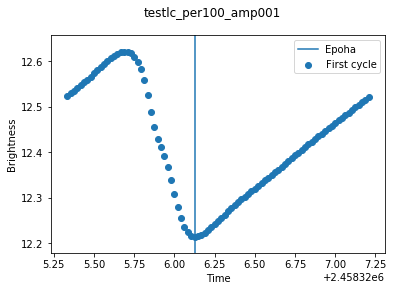

 [-----------------100%-----------------] 100000 of 100000 complete in 48.2 sec
x0    40.38390553071254
x1     -222.53655642531183
x2     477.1274157469455
x3     -491.7091826830774
x4     238.66712852023718
x5     -29.624637164632887
 [-----------------100%-----------------] 100000 of 100000 complete in 48.3 sec
x0    21.5172592672646
x1     -310.7772229691488
x2     1778.0316755629685
x3     -5025.875912411154
x4     6997.745640003288
x5     -3810.733466109347
 [-----------------100%-----------------] 100000 of 100000 complete in 46.9 sec
x0    47.7072810754122
x1     -1162.8542110259077
x2     11323.666246563378
x3     -55060.75137098551
x4     133674.73086482874
x5     -129602.28598705376
 [-----------------100%-----------------] 100000 of 100000 complete in 45.3 sec
x0    12.344462926604432
x1     -401.78867583426353
x2     5207.757836542664
x3     -33578.23015668408
x4     107613.92774522024
x5     -136991.65767321762
 [-----------------100%-----------------] 100000 of 100000 com

/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 51.2 sec
x0    0.28111440673951965
x1     -29.700584786546276
x2     699.0100730088727
x3     24379.744684630845
x4     -1291030.5553576099
x5     15155621.848390542


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 44.9 sec
x0    0.23147355788536594
x1     -25.777506256216636
x2     639.6978010162642
x3     23482.22803172229
x4     -1311184.891671354
x5     16223974.794314127


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 43.4 sec
x0    0.26380336425810447
x1     -30.847856149130788
x2     803.2454266927188
x3     31052.29175042465
x4     -1819298.995039852
x5     23637669.80625283


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 44.7 sec
x0    0.2246728018097072
x1     -27.551518470758136
x2     752.5532558880607
x3     30475.91179632641
x4     -1872995.7596757184
x5     25520376.87935923


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 47.9 sec
x0    0.21703500123395847
x1     -29.0621974374144
x2     866.5075532545171
x3     38371.27830180944
x4     -2574168.5940266526
x5     38299371.69472581


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 45.0 sec
x0    0.17808031740982708
x1     -24.86463197415805
x2     773.2988746067564
x3     35655.521659383216
x4     -2495056.1279770075
x5     38708035.427867524


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 47.4 sec
x0    0.2088642118060222
x1     -30.32477933144323
x2     980.073672090724
x3     47108.7889041768
x4     -3425695.3505498744
x5     55263546.01089826


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned


 [-----------------100%-----------------] 100000 of 100000 complete in 42.0 sec
x0    0.17740036989611727
x1     -26.768188348908915
x2     899.3327890908591
x3     44880.01610856947
x4     -3392665.8487210236
x5     56880227.3675884


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 39.2 sec
x0    0.20037820875837759
x1     -31.354990350603185
x2     1091.954326139691
x3     56612.92867486516
x4     -4436070.568841811
x5     77127855.00281417


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 42.4 sec
x0    0.17515730418833012
x1     -28.40494060592185
x2     1025.3596929339294
x3     55054.722803303215
x4     -4471595.868329679
x5     80572071.62705098


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 42.8 sec
x0    0.14250575039333188
x1     -23.926800221736393
x2     894.5462892224705
x3     49659.88418614792
x4     -4177443.6180499513
x5     77932393.03348231


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 40.0 sec
x0    0.09508830228633075
x1     -32.61400234099722
x2     2487.189219113543
x3     283728.23095065664
x4     -48684431.31569734
x5     1855343851.2877386


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 44.9 sec
x0    0.08808866037891992
x1     -30.711058360675437
x2     2380.3525709862497
x3     276157.6341314004
x4     -48159969.16323016
x5     1865598779.5873637


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 39.5 sec
x0    0.09316621369103784
x1     -33.004415508478395
x2     2598.796337302468
x3     306596.8591050973
x4     -54318827.28397669
x5     2138066818.4222784


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 40.8 sec
x0    0.08793130651622645
x1     -31.652291475835856
x2     2534.1165186270932
x3     303023.0181330344
x4     -54585897.554571144
x5     2183229787.6414833


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 37.7 sec
x0    0.09089327639820757
x1     -33.22893432031105
x2     2701.141702308567
x3     328378.22359199286
x4     -60060397.77248251
x5     2439664960.925113


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 49.7 sec
x0    0.08711906359942748
x1     -32.34324205132617
x2     2670.4776922547258
x3     329416.9510201236
x4     -61197635.18910497
x5     2524424364.9665623


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 40.1 sec
x0    0.0859521814084887
x1     -32.880171120587185
x2     2797.1464288652965
x3     355634.28918626334
x4     -68071906.10086492
x5     2893359835.9066973


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 44.5 sec
x0    0.08057327668456818
x1     -31.277996297560268
x2     2699.9909015622015
x3     348446.1155199979
x4     -67677144.70108724
x5     2919088624.205813


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 43.4 sec
x0    0.07197300662750364
x1     -28.350233437800426
x2     2484.02468893544
x3     324877.60989959666
x4     -64047583.108122826
x5     2803154832.3836546


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 43.7 sec
x0    0.08033204536294683
x1     -32.092323926447015
x2     2851.277984155662
x3     378507.64546038903
x4     -75665222.14427488
x5     3358660025.7059674


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 43.6 sec
x0    0.07335553365625988
x1     -29.717906623402133
x2     2676.360162638995
x3     360905.8669685408
x4     -73131229.35412566
x5     3291891515.655502


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 45.7 sec
x0    0.07954705852617851
x1     -32.679660946391536
x2     2986.679342208541
x3     407227.45614749653
x4     -83739843.28112337
x5     3822460668.0381556


/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:212: RankWarning: Polyfit may be poorly conditioned
/Users/batty/opt/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:196: RankWarning: Polyfit may be poorly conditioned

 [-----------------100%-----------------] 100000 of 100000 complete in 48.5 sec
x0    0.07408086237239565
x1     -30.851927013675027
x2     2857.7413823671795
x3     395337.7997758576
x4     -82393400.80617565
x5     3812642649.627107
Calculating O-C...


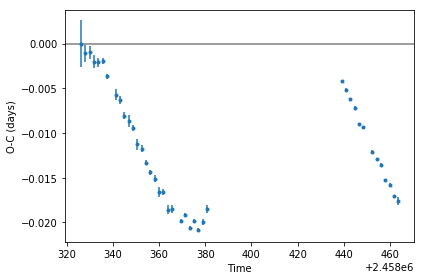

Sigma clipping...


'\nlinear = polyfit(x,y, 1, w=yerr, full=False, cov=True)\nprint(np.sqrt(np.diag(linear[1])))\n'

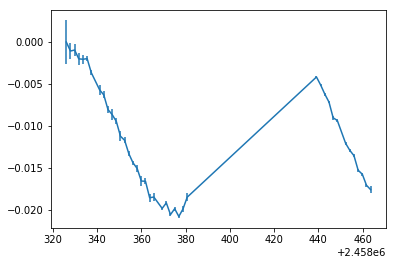

In [2]:
### RUN ####
npools = 4
names = ['testlc_per100_amp001']
periods = [1.8836187]

for name,period in zip(names,periods):
    lc = load_sectors(name,'*.txt')
    lc,splits = split_data_label(lc)

    for i in splits:
        um = np.where(lc[:,-1]==i)[0]
        time = lc[um,0]
        mag = lc[um,1]
        err = lc[um,2]
        time,mag,err = sigma_clipping(time,mag,4.,err=err,plot=False)
        if i==0:
            time_final = time
            mag_final  = mag
            err_final  = err
        else:
            time_final = np.hstack((time_final,time))
            mag_final  = np.hstack((mag_final,mag))
            err_final  = np.hstack((err_final,err))

    lc = np.c_[time_final,mag_final,err_final]
    mintimes,mintimes_err = calculate_mintimes(name,lc,period,range_from=0.1,range_to=0.3,n_range=20,order=5,plot=True,npools=npools)
    OC,OC_err = calculate_OC(name,period,mintimes,err=mintimes_err,plot=True)

    OC_time,OC_value,OC_err = sigma_clipping(OC[:,0],OC[:,1],3,err=OC_err,plot=False,kernel='Median')
    plt.errorbar(OC_time,OC_value,yerr=OC_err)
    plt.savefig(name+'_OC_sigma.pdf',format='pdf',dpi=100)

'''
linear = polyfit(x,y, 1, w=yerr, full=False, cov=True)
print(np.sqrt(np.diag(linear[1])))
'''
